# Lane Change Optimal Control using CVXPY  
This notebook solves a constrained optimal control problem for lateral motion of a vehicle.  
It uses:
- Discrete-time double-integrator model  
- Constraints on velocity, acceleration, jerk  
- Slack variables for soft constraint handling  
- An obstacle constraint during a specific time window  
- OSQP solver  


In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [3]:
# Helper function for clean interactive inputs (optional)
def get_input(prompt, default, cast=float, validator=None):
    while True:
        s = input(f"{prompt} [{default}]: ").strip()
        if s == "":
            return default
        try:
            val = cast(s)
            if validator is None or validator(val):
                return val
            print("Validation failed. Try again.")
        except:
            print("Invalid input. Try again.")

## Define Parameters (Interactive Input)
You can either:
- Press **Enter** for all defaults  
- OR enter your own values  

This makes the notebook behave like your script.


In [4]:
dt = get_input("dt (s)", 0.1, float, lambda v: v>0)
N = get_input("N (steps, integer >=1)", 50, int, lambda v: v>=1)
init_y = get_input("init_y (m)", 0.0, float)
init_vy = get_input("init_vy (m/s)", 0.0, float)
target_y = get_input("target_y (m)", 3.5, float)
final_vy_target = get_input("final_vy_target (m/s)", 0.0, float)
u_max = get_input("u_max (m/s^2)", 3.0, float, lambda v: v>=0)
v_max = get_input("v_max (m/s)", 2.0, float, lambda v: v>=0)
jerk_max = get_input("jerk_max (m/s^3)", 2.0, float, lambda v: v>=0)
penalty_slack = get_input("penalty_slack", 1e6, float, lambda v: v>0)

plot_result = input("plot_result (y/n) [y]: ").strip().lower()
if plot_result == "":
    plot_result = "y"

dt (s) [0.1]:  
N (steps, integer >=1) [50]:  
init_y (m) [0.0]:  
init_vy (m/s) [0.0]:  
target_y (m) [3.5]:  
final_vy_target (m/s) [0.0]:  
u_max (m/s^2) [3.0]:  
v_max (m/s) [2.0]:  
jerk_max (m/s^3) [2.0]:  
penalty_slack [1000000.0]:  
plot_result (y/n) [y]:  y


## Build the Optimization Model  
We construct:
- Dynamics: `x(k+1) = A x(k) + B u(k)`  
- Constraints on:  
  - Acceleration  
  - Velocity  
  - Jerk  
  - Slack variables  
- Obstacle constraints between 2.5s and 4.5s  
- Objective: Minimize effort + slack penalties


In [5]:
# Dynamics matrices
A = np.array([[1.0, dt],
              [0.0, 1.0]])

B = np.array([[0.5 * dt * dt],
              [dt]])

# Decision variables
u = cp.Variable((N, 1))
x = cp.Variable((2, N+1))
slack_u = cp.Variable((N, 1))
slack_v = cp.Variable((N+1, 1))
slack_final = cp.Variable((1, 1))

constraints = []
cost = 0

# Initial condition
constraints += [x[:, 0] == np.array([init_y, init_vy], dtype=float)]

# Dynamics + constraints
for k in range(N):
    constraints += [x[:, k+1] == A @ x[:, k] + B[:, 0] * u[k, 0]]
    constraints += [cp.abs(u[k, 0]) <= u_max + slack_u[k, 0]]

    if k > 0:
        constraints += [cp.abs(u[k, 0] - u[k-1, 0]) <= jerk_max]

    cost += cp.sum_squares(u[k, 0])

# Velocity constraints
for k in range(N+1):
    constraints += [cp.abs(x[1, k]) <= v_max + slack_v[k, 0]]

# Final constraints
constraints += [x[1, N] == final_vy_target]
constraints += [x[0, N] == target_y + slack_final[0, 0]]

# Slack constraints
constraints += [slack_u >= 0, slack_v >= 0, slack_final >= 0]

# Slack penalty
cost += penalty_slack * (
    cp.sum_squares(slack_u)
    + cp.sum_squares(slack_v)
    + cp.sum_squares(slack_final)
)

# Obstacle: between 2.5s and 4.5s
k_obs_start = int(2.5 / dt)
k_obs_end   = int(4.5 / dt)

k_obs_start = max(0, min(N-1, k_obs_start))
k_obs_end   = max(k_obs_start+1, min(N, k_obs_end))

for k in range(k_obs_start, k_obs_end):
    constraints += [x[0, k] >= target_y]

In [6]:
prob = cp.Problem(cp.Minimize(cost), constraints)
result = prob.solve(solver=cp.OSQP, verbose=False)

print("Solve status:", prob.status)

Solve status: optimal


## Extract and Visualize the Solution  
If the problem is feasible, we plot:
- Lateral position vs time  
- Lateral acceleration vs time  

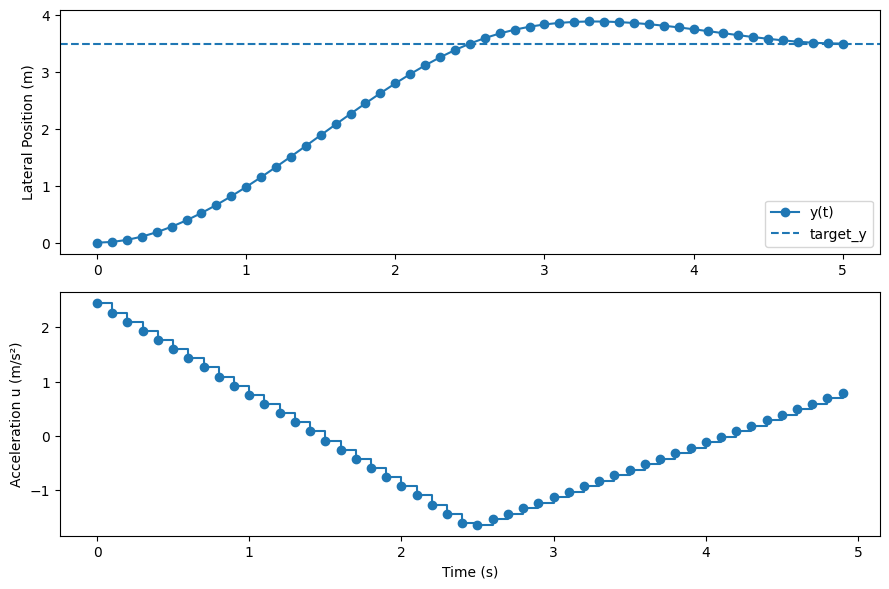

In [7]:
if prob.status in ["optimal", "optimal_inaccurate"]:
    x_np = np.array(x.value)
    u_np = np.array(u.value).reshape(-1)
    t = np.arange(N+1) * dt

    if plot_result.startswith("y"):
        fig, axs = plt.subplots(2, 1, figsize=(9, 6))

        # Position
        axs[0].plot(t, x_np[0, :], marker='o', label='y(t)')
        axs[0].axhline(target_y, linestyle='--', label='target_y')
        axs[0].set_ylabel("Lateral Position (m)")
        axs[0].legend()

        # Control
        axs[1].step(np.arange(N) * dt, u_np, where='post', marker='o')
        axs[1].set_xlabel("Time (s)")
        axs[1].set_ylabel("Acceleration u (m/s²)")

        plt.tight_layout()
        plt.show()

else:
    print("Optimization failed or infeasible.")